# Dimensionality Reduction

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

We will continue to work with the Crime data introduced in Week 8

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline

# Load some crime data
headers = pd.read_csv('comm_names.txt', squeeze=True)
headers = headers.apply(lambda s: s.split()[1])
crime = (pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data', 
                    header=None, na_values=['?'], names=headers)
         .iloc[:, 5:]
         .dropna()
         )

# Set target and predictors
target = 'ViolentCrimesPerPop'
predictors = [c for c in crime.columns if not c == target]

# Train/test split
X = crime[predictors]
y = crime[[target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [3]:
X_train.shape

(239, 121)

In [4]:
X_train.head()

,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
54,0.23,0.28,0.76,0.08,0.01,0.32,0.37,0.22,0.61,0.09,...,0.46,0.08,0.16,0.29,0.09,0.01,0.56,0.0,1.00,0.12
41,0.58,0.01,0.83,0.13,0.21,0.44,0.49,0.29,0.25,0.06,...,0.11,0.05,0.16,0.20,0.06,0.04,0.22,0.5,0.59,0.48
13,0.47,0.74,0.37,0.08,0.05,0.49,0.57,0.40,0.34,0.27,...,0.00,0.63,0.07,0.08,0.37,0.04,0.74,0.5,0.84,0.09
1,0.45,0.83,0.34,0.04,0.01,0.48,0.53,0.36,0.37,0.30,...,0.07,0.39,0.12,0.09,0.04,0.01,0.00,0.0,0.36,0.01
19,0.43,0.04,0.89,0.09,0.06,0.45,0.48,0.31,0.46,0.13,...,0.29,0.16,0.12,0.07,0.04,0.01,0.81,1.0,0.56,0.09


In Week five we build a linear model with this data. The problem was that there were too many variables and so it was too easy to overfit. We used regularization to solve this problem.

This week, we will use a different strategy. Instead of regularization, we will reduce overfitting by reducing the number of variables that are used in the model. First, we will make sure we understand how to use PCA.

### Learn the principal components of the training data

First lets look at the covariance of the training data, which tells us about the relationships between the various variables.

In [6]:
covar = X_train.cov()
covar.head().round(2)

,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
householdsize,0.02,-0.00,-0.01,0.01,0.02,0.01,0.01,0.00,-0.01,0.00,...,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.0
racepctblack,-0.00,0.09,-0.06,-0.02,-0.02,0.01,0.01,0.01,-0.00,0.01,...,-0.01,0.01,0.00,0.02,0.01,0.00,-0.01,0.01,0.01,-0.0
racePctWhite,-0.01,-0.06,0.06,-0.01,-0.01,-0.01,-0.01,-0.01,0.01,-0.01,...,-0.00,-0.00,-0.02,-0.02,-0.01,-0.01,0.01,-0.01,-0.01,0.0
racePctAsian,0.01,-0.02,-0.01,0.06,0.02,-0.00,0.00,0.00,-0.01,0.01,...,0.01,-0.00,0.02,0.01,-0.00,0.00,0.01,0.01,-0.00,-0.0
racePctHisp,0.02,-0.02,-0.01,0.02,0.06,0.00,0.01,0.00,-0.01,0.01,...,0.01,-0.00,0.03,0.01,0.00,0.00,0.00,0.01,0.00,-0.0


Total Variance

In [7]:
np.trace(covar)

4.5646812840617415

Now lets transform the data into principal component space.

In [8]:
pca = PCA()
X_transformed = pca.fit_transform(X_train)

In [10]:
pd.DataFrame(X_transformed).head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,-0.835436,-0.782788,-0.240360,-0.546547,0.155633,0.413783,0.031923,0.164605,0.571219,-0.375413,...,0.002787,-0.009088,-0.006674,0.001066,0.002344,-0.001072,-0.004996,0.002008,-0.001231,0.000531
1,0.482213,-0.533173,-0.427922,0.475401,-0.271597,0.056032,-0.056781,0.200377,-0.640000,0.674431,...,0.000891,-0.015754,0.002402,0.002503,-0.002733,-0.005956,0.002562,-0.001938,-0.001192,-0.000249
2,-0.958639,-0.132297,0.116940,0.438736,-0.216893,-0.211926,0.305924,0.308060,-0.007235,-0.230562,...,-0.008031,-0.003205,0.000035,-0.003474,-0.000604,-0.000791,0.002741,-0.005113,0.002432,0.000446
3,-1.112468,-0.161564,0.005551,0.184264,-0.042920,-0.892427,0.541019,0.592848,0.461473,-0.163100,...,-0.005494,0.004937,-0.003637,0.000213,0.001290,-0.000079,-0.001456,-0.005941,-0.002815,-0.000394
4,-0.465933,-0.782386,-0.341636,0.523286,0.042809,0.104373,-0.545111,-0.626676,0.008542,0.215413,...,0.005067,-0.007544,-0.002542,-0.003181,-0.002574,-0.001933,0.000923,-0.008091,-0.001164,-0.000052


What does the covariance look like now?

In [12]:
new_covar = pd.DataFrame(X_transformed).cov()

In [16]:
new_covar.round(2)

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,1.0,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.0,...,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
1,0.0,0.94,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.0,...,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
2,0.0,0.00,0.37,0.00,0.00,0.00,0.00,-0.00,0.00,0.0,...,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
3,0.0,-0.00,0.00,0.34,-0.00,0.00,-0.00,-0.00,-0.00,0.0,...,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0
4,-0.0,-0.00,0.00,-0.00,0.23,0.00,0.00,0.00,-0.00,-0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
5,-0.0,0.00,0.00,0.00,0.00,0.19,0.00,0.00,-0.00,-0.0,...,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
6,0.0,0.00,0.00,-0.00,0.00,0.00,0.16,0.00,0.00,-0.0,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0
7,0.0,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.15,-0.00,0.0,...,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
8,-0.0,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.11,-0.0,...,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
9,-0.0,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.1,...,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0


In [14]:
X_transformed.shape

(239, 121)

What about the total variance?

In [17]:
np.trace(new_covar)

4.5646812840617423

The explained variance is also an attribute of the PCA object

In [19]:
np.sum(pca.explained_variance_)

4.5455821991911893

### Exercise

A typical rule of thumb is to keep the components that account for 90% of the total variance. Use PCA to create a new data frame X_reduced. The total variance in the columns of X_reduced should account for about 90% of the variance in X_train

Fit PCA to the training data

In [20]:
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Scree plot of explained variance

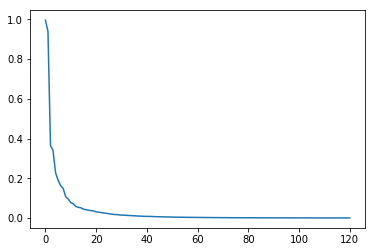

In [22]:
plt.plot(pca.explained_variance_)

Decide how many components to use

In [26]:
np.sum(np.cumsum(pca.explained_variance_ratio_) < .9)

20

In [27]:
X_train.shape

(239, 121)

#### Method One

Create a new PCA object that is explicity a dimension reducer

In [28]:
X_transformed = PCA(n_components=20).fit_transform(X_train)

In [29]:
X_transformed.shape

(239, 20)

In [31]:
X_transformed[:5, :5]

array([[-0.83543565, -0.78278795, -0.24035994, -0.54654713,  0.15563304],
       [ 0.48221287, -0.5331727 , -0.42792212,  0.47540061, -0.27159707],
       [-0.95863882, -0.13229706,  0.11693975,  0.43873554, -0.21689277],
       [-1.11246824, -0.16156369,  0.00555115,  0.18426371, -0.04292035],
       [-0.46593257, -0.78238634, -0.34163554,  0.5232864 ,  0.04280874]])

#### Method Two

Transform the data using the original PCA, but keep only the first num_comp columns

In [32]:
X_transformed = pca.transform(X_train)[:, :20]

In [33]:
X_transformed.shape

(239, 20)

In [34]:
X_transformed[:5, :5]

array([[-0.83543565, -0.78278795, -0.24035994, -0.54654713,  0.15563304],
       [ 0.48221287, -0.5331727 , -0.42792212,  0.47540061, -0.27159707],
       [-0.95863882, -0.13229706,  0.11693975,  0.43873554, -0.21689277],
       [-1.11246824, -0.16156369,  0.00555115,  0.18426371, -0.04292035],
       [-0.46593257, -0.78238634, -0.34163554,  0.5232864 ,  0.04280874]])

#### Method Three

The key to understanding PCA is the following equation:

$$
\underset{m \times n}M \approx \underset{m \times k}U \times \underset{k \times n}V^T
$$

- $M$ is the original data matrix (as long as each column has zero mean)
- $k$ is the dimension to reduce to
- $U$ maps from rows of M to components
- $V^T$ maps from components to columns of M (features)

In [37]:
M = X_train - X_train.mean()
Vt = pca.components_[:20, :]
U = np.matmul(M, np.transpose(Vt))

In [38]:
U.shape

(239, 20)

In [39]:
U[:5, :5]

array([[-0.83543565, -0.78278795, -0.24035994, -0.54654713,  0.15563304],
       [ 0.48221287, -0.5331727 , -0.42792212,  0.47540061, -0.27159707],
       [-0.95863882, -0.13229706,  0.11693975,  0.43873554, -0.21689277],
       [-1.11246824, -0.16156369,  0.00555115,  0.18426371, -0.04292035],
       [-0.46593257, -0.78238634, -0.34163554,  0.5232864 ,  0.04280874]])

### Exercise

The component matrix $V$ tells us the mapping between principal components and the original features. Use this matrix to try to interpret the first two principal components

In [44]:
comp0 = pd.Series(dict(zip(X_train.columns, Vt[0, :])))
comp1 = pd.Series(dict(zip(X_train.columns, Vt[1, :])))
col_order = comp0.sort_values().index

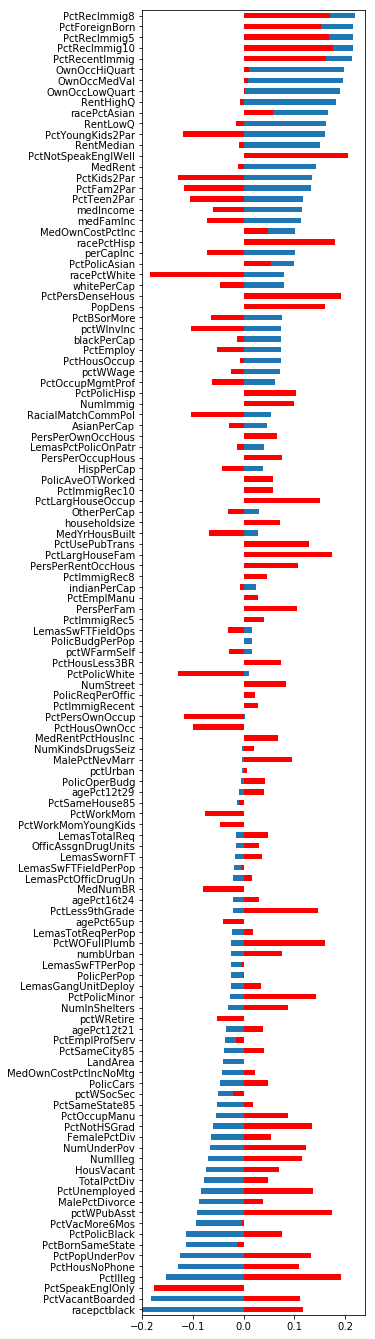

In [45]:
plt.figure(figsize=(4, 24))
comp0[col_order].plot(kind='barh')
comp1[col_order].plot(kind='barh', color='red')

- The first component ranges from wealthy immigrant neighborhoods, to poor native neighborhoods.
- The second component ranges from poor immigrant neighborhoods to wealthy native neighborhoods.
- These do seem to be orthogonal

## Application: Linear Regression

We tried regularized regression on this dataset before. Let's remind ourselves of the results

#### Vanilla

In [46]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

print 'Train R-squared: {:.3}'.format(lr.score(X_train, y_train))
print 'Test R-squared: {:.3}'.format(lr.score(X_test, y_test))

Train R-squared: 0.823
Test R-squared: 0.509


#### Lasso

In [47]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(alphas= 2. ** np.arange(-10, 10))
lasso.fit(X_train, y_train)

print 'Train R-squared: {:.3}'.format(lasso.score(X_train, y_train))
print 'Test R-squared: {:.3}'.format(lasso.score(X_test, y_test))

Train R-squared: 0.661
Test R-squared: 0.722


/Users/zalexander/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Using Dimensionality Reduction

The reason the un-regularized model does so poorly is that there are way too many features compared to the number of observations. Another approach to regularization is simply to choose a smaller number of features.

## Exercise

Below are three approaches to reducing the number of features used in the model. For each approach, 

1. Plot the R-squared (on X_test) vs number of features used.
2. Report the best R-squared
3. Report the number of features used to get the best R-squared

#### 1. Randomly choose subsets of features

This is the most naive approach to dimensionality reduction; just pick $k$ features at random.

#### 2. Intelligently choose subsets of features

We can do a little better than randomly choosing sets of features. Use the sklearn function `f_regression` to rank the features in order of their correlation with the target, then pick the top $k$ features.

In [48]:
from sklearn.feature_selection import f_regression

#### 3. Intelligently choose a projections into principal component space

Lastly, we can use PCA to compress as much information into as few features as possible. The number of features to use is the number of principal components.

## Bonus: Kernel PCA

### Exercise

Instead of vanilla PCA, try using a nonlinear kernel. See if you can find kernel parameters that improve the regression model.

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV